In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from dynadojo.systems.static_dataset import StaticDatasetSystem
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.utils.lds import plot
from dynadojo.baselines.sindy import SINDy
import numpy as np

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

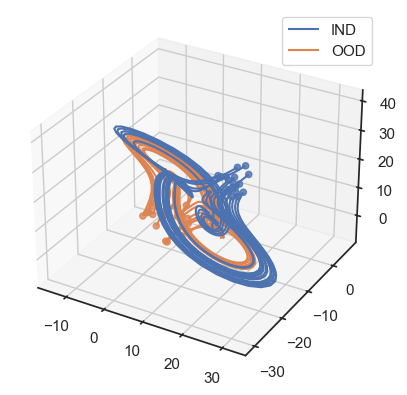

In [30]:
latent_dim = 3
embed_dim = latent_dim
n = 80
test_size = 20
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(30, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=True)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

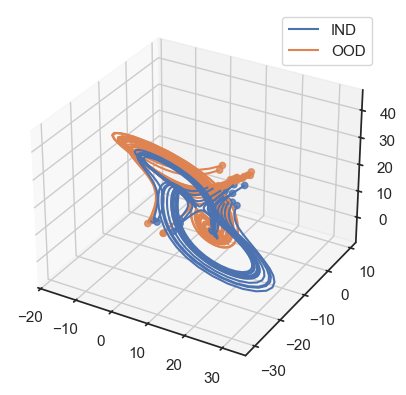

In [32]:
data = np.concatenate([x, y], axis=0)

latent_dim = 3
embed_dim = latent_dim
n = 80
test_size = 20
timesteps = 100
system = SystemChecker(StaticDatasetSystem(latent_dim, embed_dim, data, seed=42))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps)

plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

y_err=1.1795255112016891


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

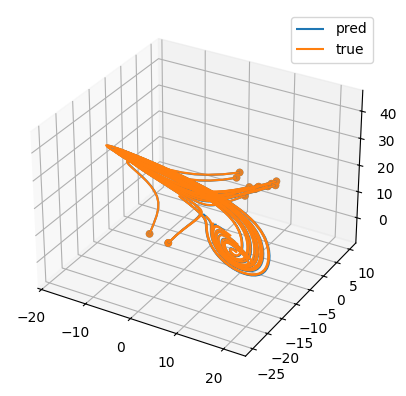

In [12]:
sindy = AlgorithmChecker(SINDy(embed_dim, timesteps, max_control_cost=0, seed=100))
sindy.fit(x)
y_pred = sindy.predict(y[:, 0], timesteps)
y_err = system.calc_error(y, y_pred)
print(f"{y_err=}")
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [13]:
from dynadojo.baselines.lr import LinearRegression
from dynadojo.challenges import FixedComplexity

In [14]:
challenge = FixedComplexity(
    N=[10, 50, 80],
    l=3,
    e=3,
    t=100,
    control_horizons=0,
    max_control_cost_per_dim=0,
    system_cls=StaticDatasetSystem,
    trials=10,
    test_examples=20,
    test_timesteps=100,
    system_kwargs={"data": data},
)
data = challenge.evaluate(LinearRegression, id="linear regression")

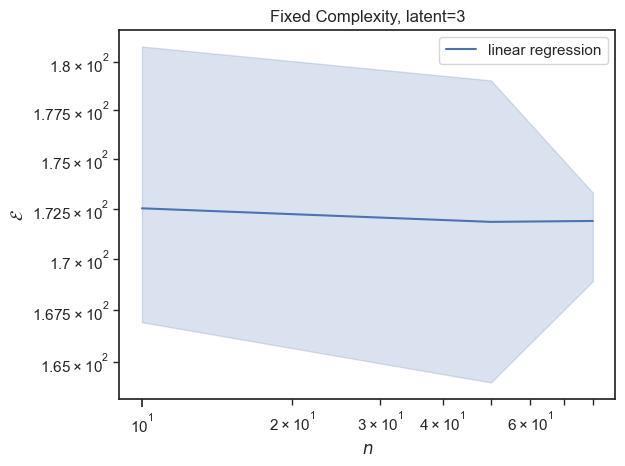

<Axes: title={'center': 'Fixed Complexity, latent=3'}, xlabel='$n$', ylabel='$\\mathcal{E}$'>

In [15]:
challenge.plot(data)

(10, 3, 3)


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

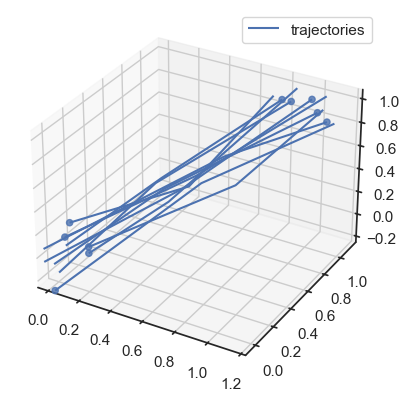

In [60]:
import numpy as np

def generate_opposing_trajectories(num_trajectories=10, num_timesteps=10, dim=3, noise_std=0.05, lateral_offset=0.5):
    np.random.seed(0)
    
    trajectories = np.zeros((num_trajectories, num_timesteps, dim))
    
    origin = np.array([0, 0, 0])
    end_point = np.array([1, 1, 1])
    
    for i in range(num_trajectories):
        if i < (num_trajectories * 0.5):
            start = origin
            end = end_point
        else:
            start = end_point
            end = origin
        
        t = np.linspace(0, 1, num_timesteps)
        trajectory = (1 - t[:, None]) * start + t[:, None] * end
        
        noise = np.random.normal(scale=noise_std, size=(num_timesteps, dim))
        trajectory += noise
        
        trajectories[i] = trajectory
    
    return trajectories

trajectories = generate_opposing_trajectories(num_trajectories=10, num_timesteps=3, dim=3, noise_std=0.1)

print(trajectories.shape)
plot([trajectories], target_dim=3, labels=["trajectories"])

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

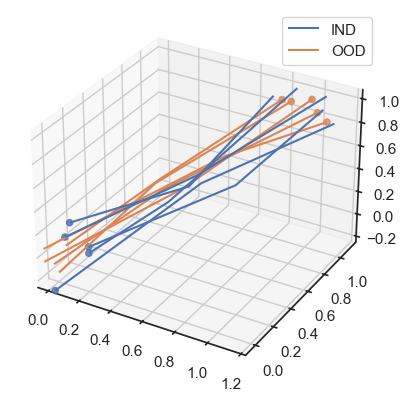

In [63]:
latent_dim = 3
embed_dim = latent_dim
n = 5
test_size = 5
timesteps = 3
system = SystemChecker(StaticDatasetSystem(latent_dim, embed_dim, trajectories, in_dist_ratio=0.5))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps)

plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

(10, 30, 3)


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

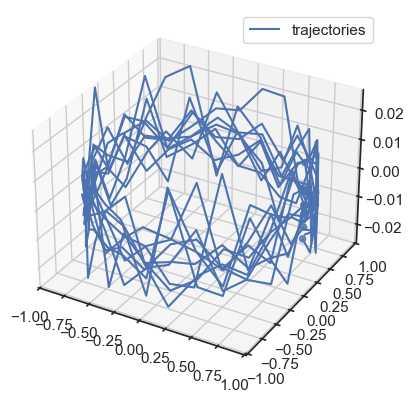

In [81]:
def generate_opposing_circular_trajectories(num_trajectories=10, num_timesteps=10, dim=3, noise_std=0.05, radius=1.0):
    np.random.seed(0)
    
    trajectories = np.zeros((num_trajectories, num_timesteps, dim))
    
    angles = np.linspace(0, 2 * np.pi, num_timesteps)

    for i in range(num_trajectories):
        if i < (num_trajectories * 0.5):
            x = radius * np.cos(angles)
            y = radius * np.sin(angles)
        else:
            x = radius * np.cos(-angles)
            y = radius * np.sin(-angles)
        
        z = np.linspace(0, 0, num_timesteps)

        trajectory = np.vstack((x, y, z)).T
        
        noise = np.random.normal(scale=noise_std, size=(num_timesteps, dim))
        trajectory += noise
        
        trajectories[i] = trajectory

    return trajectories

trajectories = generate_opposing_circular_trajectories(num_trajectories=10, num_timesteps=30, dim=3, noise_std=0.01)

print(trajectories.shape)
plot([trajectories], target_dim=3, labels=["trajectories"])

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

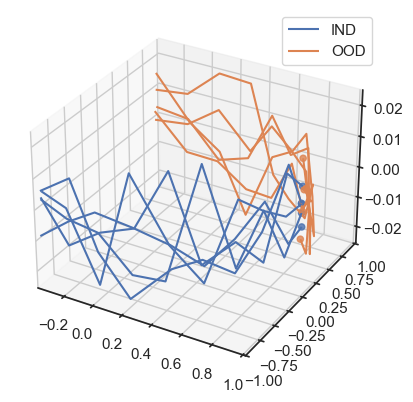

In [82]:
latent_dim = 3
embed_dim = latent_dim
n = 5
test_size = 5
timesteps = 10
system = SystemChecker(StaticDatasetSystem(latent_dim, embed_dim, trajectories, in_dist_ratio=0.5))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps)

plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)